**Libraries and Google Drive**

In [0]:
# Dataset : temperatures in Rio, Brazil
# https://www.kaggle.com/volpatto/temperature-timeseries-for-some-brazilian-cities?select=station_rio.csv

In [104]:
# We mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
# We import some dl libraries
import pandas as pd
import tensorflow as tf
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

In [210]:
# We import the dataset from Google Drive
initial_data = pd.read_csv('/content/drive/My Drive/rio_time_series/station_rio.csv')
initial_data.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,D-J-F,M-A-M,J-J-A,S-O-N,metANN
0,1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,27.45,24.87,21.98,22.33,24.16
1,1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54,26.56,24.42,21.24,23.41,23.91
2,1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53,25.58,23.54,21.05,23.05,23.31
3,1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56,26.74,24.18,20.82,22.58,23.58
4,1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84,27.07,24.48,22.50,23.61,24.42


**Preparation of the dataset**

In [211]:
# We drop the columns with mean values
initial_data = initial_data.drop(['D-J-F','M-A-M', 'J-J-A', 'S-O-N', 'metANN'], axis = 1)
initial_data.head()

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1973,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85
1,1974,26.68,27.16,26.56,23.94,22.76,20.70,21.20,21.81,22.91,22.80,24.51,24.54
2,1975,25.27,26.92,26.43,22.82,21.37,20.50,19.68,22.98,22.40,22.65,24.11,26.53
3,1976,27.48,26.20,25.55,24.99,22.01,21.18,20.14,21.15,21.27,22.06,24.40,25.56
4,1977,27.13,28.51,26.88,24.22,22.35,22.13,23.07,22.29,22.44,23.92,24.48,24.84


In [212]:
# Instead of modifying the current dataset, we will build another one from it

import numpy as np
from datetime import datetime, timedelta

# First, create the dates column
days = pd.date_range('01-01-1973', '01-01-2020', freq='M')
data = pd.DataFrame({'date': days})
print(data)

          date
0   1973-01-31
1   1973-02-28
2   1973-03-31
3   1973-04-30
4   1973-05-31
..         ...
559 2019-08-31
560 2019-09-30
561 2019-10-31
562 2019-11-30
563 2019-12-31

[564 rows x 1 columns]


In [213]:
# Then, we transfer the data accordingly
array_tp = []

def get_temperature(row):
  num_to_month = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
  array_tp.append(float(initial_data[initial_data['YEAR'] == row['date'].year][num_to_month[row['date'].month - 1]]))

data.apply(get_temperature, axis = 1)
data['tp'] = array_tp

data.head()

,date,tp
0,1973-01-31,27.73
1,1973-02-28,27.97
2,1973-03-31,25.70
3,1973-04-30,26.49
4,1973-05-31,22.42


In [214]:
# detect some errors in the dataset
data['tp'].describe()

count    564.000000
mean     105.565177
std      269.901335
min       19.240000
25%       22.420000
50%       24.570000
75%       26.765000
max      999.900000
Name: tp, dtype: float64

In [215]:
# Some temperatures are set to 999, probably because it corresponds to missing datapoints
data[data['tp'] > 900]['date'].dt.year.value_counts()

2003    11
1985    11
2007     9
1993     6
2019     2
2004     2
1994     2
1986     2
2015     1
1992     1
Name: date, dtype: int64

In [0]:
# Let's set these missing values to NaN
data.loc[data['tp'] > 900, 'tp'] = None

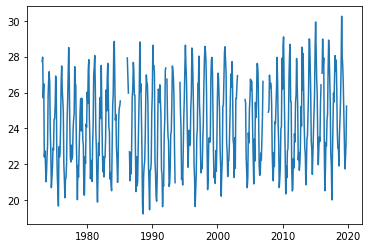

In [217]:
# Let's plot this without the missing values
import matplotlib.pyplot as plt 

plt.plot(data['date'], data['tp'])
# Global warming in action

**Train/test split**

In [0]:
# train/test : We choose to predict the year 2019 from 2018 and 2017
data_test = data[(data['date'].dt.year >= 2017) & (data['date'].dt.year <= 2019)]
data_train = data[data['date'].dt.year <= 2018]

**Transform the data into a supervised problem**

In [0]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [220]:
# Using one year of data (window = 11), we will predict the timestamp 1 year later (lag = 12)
window = 11
lag = 12
series_train = series_to_supervised(data_train.drop('date', axis=1), window=window, lag=lag)
series_test = series_to_supervised(data_test.drop('date', axis=1), window=window, lag=lag)
series_train.head()

,tp(t-11),tp(t-10),tp(t-9),tp(t-8),tp(t-7),tp(t-6),tp(t-5),tp(t-4),tp(t-3),tp(t-2),tp(t-1),tp(t),tp(t+12)
11,27.73,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,24.54
12,27.97,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,26.68,25.27
13,25.70,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,26.68,27.16,26.92
14,26.49,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,26.68,27.16,26.56,26.43
15,22.42,22.76,22.14,21.03,21.46,22.46,23.06,25.85,26.68,27.16,26.56,23.94,22.82


**Train/validation split**

In [221]:
from sklearn.model_selection import train_test_split

# Label train
labels_col = 'tp(t+%d)' % lag
labels_train = series_train[labels_col]
series_train = series_train.drop(labels_col, axis=1)

# Label test
Y_test = series_test[labels_col]
X_test = series_test.drop(labels_col, axis=1)
print('Test set shape', X_test.shape)

# train/validation
X_train, X_valid, Y_train, Y_valid = train_test_split(series_train, labels_train.values, test_size=0.3, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Test set shape (11, 12)
Train set shape (265, 12)
Validation set shape (114, 12)


,tp(t-11),tp(t-10),tp(t-9),tp(t-8),tp(t-7),tp(t-6),tp(t-5),tp(t-4),tp(t-3),tp(t-2),tp(t-1),tp(t)
221,20.25,19.95,21.17,24.21,26.19,26.08,25.44,26.43,25.52,24.72,21.69,21.42
455,28.58,29.10,26.49,24.59,22.87,20.35,21.93,21.25,22.74,22.86,24.45,26.92
295,21.44,23.50,23.96,26.51,26.52,28.03,25.35,24.57,22.43,21.53,22.00,21.76
28,20.70,21.20,21.81,22.91,22.80,24.51,24.54,25.27,26.92,26.43,22.82,21.37
317,21.30,23.21,23.48,23.23,23.54,26.86,27.83,27.96,27.00,24.69,22.21,21.25


**Test MLP** : we expect poor results, because the input is not treated as sequenced data. Therefore, it's difficult to identify the time-depending patterns.

In [0]:
# Since we don't have a lot of data, let's put the entire training data into one batch
epochs = 40
batch = 265
lr = 0.0005
adam = optimizers.Adam(lr)

We build a simple model with one dense layer only (that makes two with the output layer). This is a simple problem and adding more complexity here doesn't make sense.

In [223]:
model_mlp = Sequential()
model_mlp.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
# Because we are doing time series forecasting, we will use mse as the loss function
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                832       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 65        
Total params: 897
Trainable params: 897
Non-trainable params: 0
_________________________________________________________________


In [224]:
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=1)

Train on 265 samples, validate on 114 samples
Epoch 1/40
265/265 [==============================] - 0s 510us/step - loss: 221.7815 - val_loss: 103.3712
Epoch 2/40
265/265 [==============================] - 0s 150us/step - loss: 63.5036 - val_loss: 16.4194
Epoch 3/40
265/265 [==============================] - 0s 148us/step - loss: 10.5240 - val_loss: 10.8093
Epoch 4/40
265/265 [==============================] - 0s 146us/step - loss: 12.9803 - val_loss: 15.4470
Epoch 5/40
265/265 [==============================] - 0s 142us/step - loss: 12.1198 - val_loss: 9.9061
Epoch 6/40
265/265 [==============================] - 0s 153us/step - loss: 8.2441 - val_loss: 7.2360
Epoch 7/40
265/265 [==============================] - 0s 141us/step - loss: 7.3884 - val_loss: 6.9649
Epoch 8/40
265/265 [==============================] - 0s 159us/step - loss: 7.0337 - val_loss: 6.6054
Epoch 9/40
265/265 [==============================] - 0s 159us/step - loss: 6.6949 - val_loss: 6.7547
Epoch 10/40
265/265 [====

**Test CNN** : since a CNN uses filters in order to extract information, it will be able to detect patterns and therefore produce better results.
But since the expected input is different, we need to transform the input shape a bit (from 2D array to 3D array).

In [225]:
# Input transformation
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (265, 12, 1)
Validation set shape (114, 12, 1)


We build a simple CNN model with one 1D convolutionnal, followed by a pooling layer. The output is then flattened and passed through a dense layer to produce the final prediction.

In [226]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(32, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 11, 64)            192       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 32)                10272     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 33        
Total params: 10,497
Trainable params: 10,497
Non-trainable params: 0
_________________________________________________________________


In [227]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=1)

Train on 265 samples, validate on 114 samples
Epoch 1/40
265/265 [==============================] - 0s 644us/step - loss: 75.2654 - val_loss: 52.4713
Epoch 2/40
265/265 [==============================] - 0s 170us/step - loss: 20.9855 - val_loss: 16.3733
Epoch 3/40
265/265 [==============================] - 0s 163us/step - loss: 12.8755 - val_loss: 13.8938
Epoch 4/40
265/265 [==============================] - 0s 163us/step - loss: 10.5501 - val_loss: 8.6137
Epoch 5/40
265/265 [==============================] - 0s 176us/step - loss: 8.7934 - val_loss: 8.6573
Epoch 6/40
265/265 [==============================] - 0s 173us/step - loss: 8.0989 - val_loss: 7.3458
Epoch 7/40
265/265 [==============================] - 0s 165us/step - loss: 7.8951 - val_loss: 7.0861
Epoch 8/40
265/265 [==============================] - 0s 164us/step - loss: 7.3820 - val_loss: 6.8941
Epoch 9/40
265/265 [==============================] - 0s 165us/step - loss: 7.2208 - val_loss: 6.3851
Epoch 10/40
265/265 [========

**Test LSTM** : it will consider the data as a sequence, and therefore will be the more suited solution for this kinf of problem. Moreover, its method can detect patterns better than the other ones, especially with long sequences (even if our input is pretty small here).
We can reuse the CNN input.
We build a simple model : one layer with 50 LSTM cells.

In [228]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [229]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=1)

Train on 265 samples, validate on 114 samples
Epoch 1/40
265/265 [==============================] - 1s 3ms/step - loss: 462.0049 - val_loss: 187.9328
Epoch 2/40
265/265 [==============================] - 0s 1ms/step - loss: 97.6905 - val_loss: 21.2320
Epoch 3/40
265/265 [==============================] - 0s 1ms/step - loss: 13.4482 - val_loss: 7.1813
Epoch 4/40
265/265 [==============================] - 0s 1ms/step - loss: 8.7610 - val_loss: 5.8647
Epoch 5/40
265/265 [==============================] - 0s 1ms/step - loss: 4.8403 - val_loss: 3.7517
Epoch 6/40
265/265 [==============================] - 0s 1ms/step - loss: 4.1677 - val_loss: 3.2698
Epoch 7/40
265/265 [==============================] - 0s 1ms/step - loss: 3.5426 - val_loss: 3.7702
Epoch 8/40
265/265 [==============================] - 0s 1ms/step - loss: 3.8644 - val_loss: 3.1570
Epoch 9/40
265/265 [==============================] - 0s 1ms/step - loss: 4.0772 - val_loss: 3.5435
Epoch 10/40
265/265 [==========================

We can see that the validation loss is significantly better.

**CNN-LSTM Test** : let's be a bit crazy, we will combine the CNN and LSTM model to use the strengths of the two types of models. How does it work ? We will first use a CNN to analyse the data through an ensemble of filters, and then feed these outputs to the LSTM model that will reassemble the data together.
So, the real question here : what's the point ? It enables us to treat very long sequences by applying filter on subsequences before treating them with a LSTM model.
Therefore there is no need for this kind of model here, we will just build it to try it (we could modify the parameters to treat bigger sequences, but the missing values are messing with the lagged dataset...).

We also need to reshape the input for this model (4D input : samples, subsequences, timesteps, features)

In [230]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (265, 2, 6, 1)
Validation set shape (114, 2, 6, 1)


A detail here : the TimeDistributedLayer enables us to apply the same treatment to all of the subsequences (this is very important).

In [0]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [232]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=1)

Train on 265 samples, validate on 114 samples
Epoch 1/40
265/265 [==============================] - 1s 2ms/step - loss: 227.6913 - val_loss: 33.1079
Epoch 2/40
265/265 [==============================] - 0s 412us/step - loss: 11.4681 - val_loss: 8.1967
Epoch 3/40
265/265 [==============================] - 0s 425us/step - loss: 7.2762 - val_loss: 7.1738
Epoch 4/40
265/265 [==============================] - 0s 444us/step - loss: 6.8040 - val_loss: 5.5184
Epoch 5/40
265/265 [==============================] - 0s 478us/step - loss: 5.9687 - val_loss: 5.0564
Epoch 6/40
265/265 [==============================] - 0s 434us/step - loss: 5.4690 - val_loss: 6.4873
Epoch 7/40
265/265 [==============================] - 0s 419us/step - loss: 5.5512 - val_loss: 4.2128
Epoch 8/40
265/265 [==============================] - 0s 417us/step - loss: 4.4033 - val_loss: 3.7929
Epoch 9/40
265/265 [==============================] - 0s 423us/step - loss: 4.0078 - val_loss: 3.5222
Epoch 10/40
265/265 [=============

**Comparing models**

In [0]:
epochs_series = [x for x in range (1,41)]

MLP

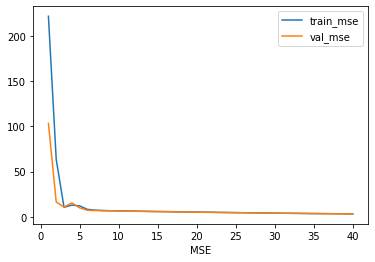

In [234]:
plt.plot(epochs_series, mlp_history.history['loss'], label='train_mse')
plt.plot(epochs_series, mlp_history.history['val_loss'], label='val_mse')
plt.xlabel('Epochs')
plt.xlabel('MSE')
plt.legend()
plt.show()

In [258]:
test_predictions_mlp = model_mlp.predict(X_test)
dates_test = data_test[(data_test['date'].dt.year == 2019) | ((data_test['date'].dt.year == 2018) & (data_test['date'].dt.month == 12))].dropna()['date'].values
print(len(test_predictions), len(dates_test))

11 11


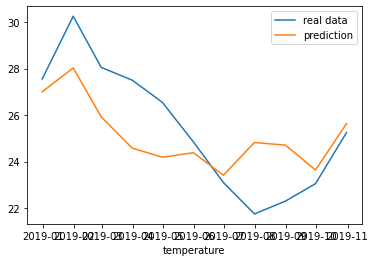

In [259]:
plt.plot(dates_test, Y_test, label='real data')
plt.plot(dates_test, test_predictions_mlp, label='prediction')
plt.xlabel('date')
plt.xlabel('temperature')
plt.legend()
plt.show()

In [273]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_mlp = sqrt(mean_squared_error(Y_test, test_predictions_mlp))
print("RMSE MLP : ", rmse_mlp)

RMSE MLP :  1.9047030073173188


CNN

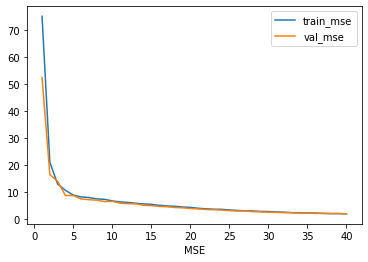

In [260]:
plt.plot(epochs_series, cnn_history.history['loss'], label='train_mse')
plt.plot(epochs_series, cnn_history.history['val_loss'], label='val_mse')
plt.xlabel('Epochs')
plt.xlabel('MSE')
plt.legend()
plt.show()

In [0]:
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
test_predictions_cnn = model_cnn.predict(X_test_series)

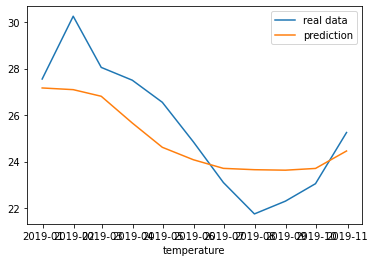

In [264]:
plt.plot(dates_test, Y_test, label='real data')
plt.plot(dates_test, test_predictions_cnn, label='prediction')
plt.xlabel('date')
plt.xlabel('temperature')
plt.legend()
plt.show()

In [274]:
rmse_cnn = sqrt(mean_squared_error(Y_test, test_predictions_cnn))
print("RMSE CNN : ", rmse_cnn)

RMSE CNN :  1.5430968836515526


LSTM

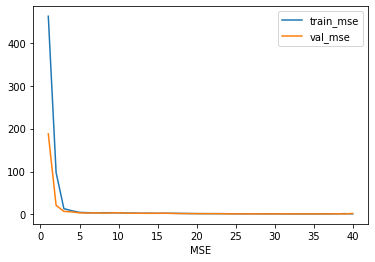

In [265]:
plt.plot(epochs_series, lstm_history.history['loss'], label='train_mse')
plt.plot(epochs_series, lstm_history.history['val_loss'], label='val_mse')
plt.xlabel('Epochs')
plt.xlabel('MSE')
plt.legend()
plt.show()

In [0]:
test_predictions_lstm = model_lstm.predict(X_test_series)

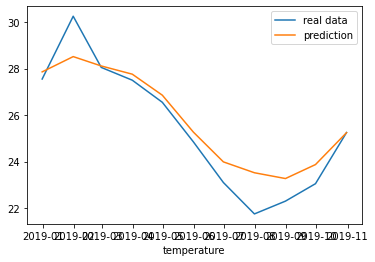

In [267]:
plt.plot(dates_test, Y_test, label='real data')
plt.plot(dates_test, test_predictions_lstm, label='prediction')
plt.xlabel('date')
plt.xlabel('temperature')
plt.legend()
plt.show()

In [275]:
rmse_lstm = sqrt(mean_squared_error(Y_test, test_predictions_lstm))
print("RMSE LSTM : ", rmse_lstm)

RMSE LSTM :  0.9038598309831148


CNN-LSTM

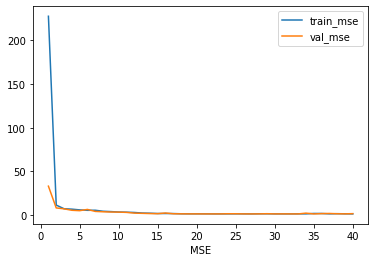

In [270]:
plt.plot(epochs_series, cnn_lstm_history.history['loss'], label='train_mse')
plt.plot(epochs_series, cnn_lstm_history.history['val_loss'], label='val_mse')
plt.xlabel('Epochs')
plt.xlabel('MSE')
plt.legend()
plt.show()

In [0]:
subsequences = 2
timesteps = X_test_series.shape[1]//subsequences
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))
test_predictions_cnn_lstm = model_cnn_lstm.predict(X_test_series_sub)

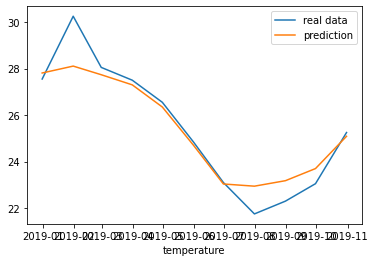

In [269]:
plt.plot(dates_test, Y_test, label='real data')
plt.plot(dates_test, test_predictions_cnn_lstm, label='prediction')
plt.xlabel('date')
plt.xlabel('temperature')
plt.legend()
plt.show()

In [276]:
rmse_cnn_lstm = sqrt(mean_squared_error(Y_test, test_predictions_cnn_lstm))
print("RMSE CNN-LSTM : ", rmse_cnn_lstm)

RMSE CNN-LSTM :  0.8263093884006969


**CONCLUSION**

We implemented several Deep Learning methods for times series forecasting. We discussed the different strengths of each type of model and saw that the results were following our expectations.
Nevertheless, these models are really basic and need to be adapted to the different kinds of problems available.  